In [1]:
import pandas as pd
import glob
from pathlib import Path
import json
import numpy as np

In [2]:
## Evaluating generation

In [3]:
# 1. load corpora
# 2. run TextGenerationEvaluator

In [4]:
## Rest

In [5]:
import json
import pickle

with open("/home/kuba/Projects/github_search/.dagster/storage/generation_metrics_df", "rb") as f:
    generation_metrics_df = pickle.load(f)


with open("/home/kuba/Projects/github_search/.dagster/storage/per_query_generation_metrics_df", "rb") as f:
    per_query_generation_metrics_df = pickle.load(f)

In [6]:

with open("/home/kuba/Projects/github_search/.dagster/storage/repos_with_representations_df", "rb") as f:
    repos_with_representations_df = pickle.load(f)

In [7]:
repos_with_representations_df.columns

Index(['repo', 'readme', 'repomap', 'tasks', 'query_tasks',
       'dependency_signature', 'generated_tasks', 'repository_signature',
       'reasoning', 'answer', 'context_history', 'filenames', 'n_files',
       'reasoning_repomap', 'answer_repomap', 'context_history_repomap',
       'filenames_repomap', 'n_files_repomap', 'reasoning_flat', 'answer_flat',
       'filenames_flat', 'n_files_flat', 'reasoning_flat_repomap',
       'answer_flat_repomap', 'filenames_flat_repomap', 'n_files_flat_repomap',
       'selected_code'],
      dtype='object')

In [8]:
#def process_generation_metrics_df(generation_metrics_df):
#    return (
#        generation_metrics_df.assign(
#            true_tasks=generation_metrics_df["true_tasks"].str.split(", ").apply(tuple)
#        ).groupby(["repo", "true_tasks"]).apply(lambda df: df.select_dtypes("float").mean())
#    )["code2doc_generated_readme", "code2doc_reasoning", "code2doc_generation_context"]

In [9]:
colorcodings = {
    "generated_tasks": "red", "repository_signature": "red", "dependency_signature": "red",
    "selected_code": "orange",
    "code2doc_generated_readme":"green", "code2doc_generation_context": "green", "code2doc_reasoning": "green",
    "generated_readme (repomap)":"cyan", "generation_context (repomap)": "cyan", "generated_rationale (repomap)": "cyan"}

def format_corpus_for_latex(corpus_name, intensity=25):
    
    if colorcodings.get(corpus_name) is None:
        return corpus_name
    else:
        color = colorcodings[corpus_name]
        corpus_name = corpus_name.replace("generation_context", "code summary")
        return f"{{\color{{{color}}} {corpus_name}}}"


def format_retriever_for_latex(retriever_name, intensity=25):
    if retriever_name == "bm25":
        pass
    elif "all-mpnet-base-v2" in retriever_name:
        retriever_name = "MPNet"
    elif "all-MiniLM-L12-v2" in retriever_name:
        retriever_name = "MiniLM"
    elif "embeddinggemma" in retriever_name:
        retriever_name = "gemma embedder"
    elif "static-retrieval" in retriever_name:
        retriever_name = "static embedder"
    elif retriever_name == "Word2Vec":
        retriever_name = retriever_name
    else:
        pass
    return retriever_name.replace("_", " ")

<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1533026/1336186513.py:14: SyntaxWarning: invalid escape sequence '\c'
  return f"{{\color{{{color}}} {corpus_name}}}"


In [10]:
#generation_metrics_df = process_generation_metrics_df(generation_metrics_df)

In [11]:
#generation_metrics_df = generation_metrics_df.reset_index()

In [12]:
#raw_ir_metrics_df = pd.read_csv("../output/code2doc/sample_per_task_5_repos/beir_results_codellama.csv")
raw_ir_metrics_df = pd.read_csv("../results/per_query_ir_results.csv")

raw_ir_metrics_df = raw_ir_metrics_df[~raw_ir_metrics_df["corpus"].isin(["flat_repomap_code2doc_files_summary", "flat_code2doc_files_summary"])]

In [13]:
raw_ir_metrics_df.columns

Index(['query', 'retriever', 'corpus', 'Hits@1', 'Hits@5', 'Hits@10',
       'Hits@25', 'Accuracy@1', 'Precision@1', 'Accuracy@5', 'Precision@5',
       'Accuracy@10', 'Precision@10', 'Accuracy@25', 'Precision@25'],
      dtype='object')

In [14]:
raw_ir_metrics_df["corpus"].unique()

array(['code2doc_files_summary', 'code2doc_generated_readme',
       'dependency_signature', 'flat_code2doc_generated_readme',
       'flat_repomap_code2doc_generated_readme', 'generated_tasks',
       'readme', 'repomap', 'repomap_code2doc_files_summary',
       'repomap_code2doc_generated_readme', 'repository_signature',
       'selected_code'], dtype=object)

In [15]:
raw_ir_metrics_df["retriever"].unique()

array(['bm25', 'google/embeddinggemma-300m',
       'sentence-transformers/all-MiniLM-L12-v2',
       'sentence-transformers/all-mpnet-base-v2',
       'sentence-transformers/static-retrieval-mrl-en-v1', 'word2vec'],
      dtype=object)

In [16]:
merged_metrics_df = raw_ir_metrics_df.merge(per_query_generation_metrics_df, left_on="query", right_on="task")

In [17]:
merged_metrics_df.select_dtypes("float").corr()[["Accuracy@10", "Precision@10"]].loc[["rougeL", "sentence_transformer_similarity"]]

,Accuracy@10,Precision@10
rougeL,0.133000,0.186072
sentence_transformer_similarity,0.098496,0.122075


In [18]:
raw_ir_metrics_df

,query,retriever,corpus,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Precision@1,Accuracy@5,Precision@5,Accuracy@10,Precision@10,Accuracy@25,Precision@25
0,2d human pose estimation,bm25,code2doc_files_summary,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.24
1,2d human pose estimation,bm25,code2doc_generated_readme,0.0,2.0,2.0,8.0,0.0,0.0,1.0,0.4,1.0,0.2,1.0,0.32
2,2d human pose estimation,bm25,dependency_signature,0.0,1.0,4.0,5.0,0.0,0.0,1.0,0.2,1.0,0.4,1.0,0.20
3,2d human pose estimation,bm25,flat_code2doc_generated_readme,0.0,1.0,4.0,9.0,0.0,0.0,1.0,0.2,1.0,0.4,1.0,0.36
4,2d human pose estimation,bm25,flat_repomap_code2doc_generated_readme,1.0,1.0,3.0,7.0,1.0,1.0,1.0,0.2,1.0,0.3,1.0,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53419,zero shot learning,word2vec,repomap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
53420,zero shot learning,word2vec,repomap_code2doc_files_summary,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04
53421,zero shot learning,word2vec,repomap_code2doc_generated_readme,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.2,1.0,0.1,1.0,0.08
53422,zero shot learning,word2vec,repository_signature,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.1,1.0,0.12


In [19]:
ir_metrics_df = raw_ir_metrics_df.drop(columns=["query"]).groupby(["corpus", "retriever"]).agg("mean").reset_index()

In [20]:
def convert_df_to_latex_table(df, cols=["corpus", "retriever", "Accuracy@10", "Precision@10"], sort_values="Accuracy@10", column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|"):
    df = df.copy()
    if "retriever" in cols:
        df["retriever"] = df["retriever"].apply(format_retriever_for_latex)
    df["corpus"] = df["corpus"].apply(format_corpus_for_latex)
    return (
        df[
            cols
        ].sort_values(sort_values, ascending=False)
        .to_latex(index_names=False, index=False, column_format=column_format, float_format="%.3f")
        .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
        .replace("Accuracy@10", "Hit@10")
    )

<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\%'
<>:11: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1533026/3586139828.py:11: SyntaxWarning: invalid escape sequence '\%'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
/tmp/ipykernel_1533026/3586139828.py:11: SyntaxWarning: invalid escape sequence '\h'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")


In [21]:
ir_metrics_best_retriever_df = ir_metrics_df.sort_values("Hits@10", ascending=False).drop_duplicates(subset=["corpus"])

In [22]:
basic_corpora = ["readme", "dependency_signature", "selected_code"]
basic_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(basic_corpora)]

## Basic corpora

In [23]:
basic_ir_metrics_best_retriever_df

,corpus,retriever,Hits@1,Hits@5,Hits@10,Hits@25,Accuracy@1,Precision@1,Accuracy@5,Precision@5,Accuracy@10,Precision@10,Accuracy@25,Precision@25
39,readme,sentence-transformers/all-mpnet-base-v2,0.641509,2.556604,4.250674,6.916442,0.641509,0.641509,0.877358,0.511321,0.928571,0.425067,0.959569,0.276658
15,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.405660,1.301887,1.912399,2.978437,0.405660,0.405660,0.657682,0.260377,0.737197,0.191240,0.815364,0.119137
66,selected_code,bm25,0.376694,1.220867,1.831978,2.917344,0.376694,0.376694,0.613821,0.244173,0.689702,0.183198,0.791328,0.116694


In [24]:
print(convert_df_to_latex_table(basic_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Hit@10 & Precision@10 \\
\hline
\midrule
\hline
readme & MPNet & 0.929 & 0.425 \\
\hline
{\color{red} dependency signature} & MPNet & 0.737 & 0.191 \\
\hline
{\color{orange} selected code} & bm25 & 0.690 & 0.183 \\
\hline
\bottomrule
\hline
\end{tabular}


## Signature corpora

In [25]:
signature_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(basic_corpora + ["repository_signature", "generated_tasks"])]

In [26]:
print(convert_df_to_latex_table(signature_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Hit@10 & Precision@10 \\
\hline
\midrule
\hline
readme & MPNet & 0.929 & 0.425 \\
\hline
{\color{red} generated tasks} & MPNet & 0.827 & 0.278 \\
\hline
{\color{red} repository signature} & MPNet & 0.786 & 0.228 \\
\hline
{\color{red} dependency signature} & MPNet & 0.737 & 0.191 \\
\hline
{\color{orange} selected code} & bm25 & 0.690 & 0.183 \\
\hline
\bottomrule
\hline
\end{tabular}


In [27]:
ir_metrics_best_retriever_df["corpus"].unique()

array(['readme', 'flat_code2doc_generated_readme',
       'flat_repomap_code2doc_generated_readme',
       'code2doc_generated_readme', 'repomap_code2doc_generated_readme',
       'generated_tasks', 'code2doc_files_summary',
       'repomap_code2doc_files_summary', 'repository_signature',
       'dependency_signature', 'selected_code', 'repomap'], dtype=object)

## Code2doc 

In [28]:
code2doc_corpora = ["readme"]

code2doc_corpora = code2doc_corpora + [c for c in ir_metrics_best_retriever_df["corpus"].unique() if "code2doc" in c]

In [29]:
#for cname in code2doc_corpora:
#    code2doc_corpora.append(cname)
#    #code2doc_corpora.append(cname + " (repomap)")

code2doc_ir_metrics_best_retriever_df = ir_metrics_best_retriever_df[ir_metrics_best_retriever_df["corpus"].isin(code2doc_corpora)]

In [30]:
print(convert_df_to_latex_table(code2doc_ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Hit@10 & Precision@10 \\
\hline
\midrule
\hline
readme & MPNet & 0.929 & 0.425 \\
\hline
flat code2doc generated readme & MPNet & 0.880 & 0.349 \\
\hline
flat repomap code2doc generated readme & MPNet & 0.871 & 0.331 \\
\hline
{\color{green} code2doc generated readme} & MPNet & 0.856 & 0.321 \\
\hline
repomap code2doc generated readme & MPNet & 0.842 & 0.313 \\
\hline
repomap code2doc files summary & bm25 & 0.804 & 0.244 \\
\hline
code2doc files summary & MPNet & 0.791 & 0.250 \\
\hline
\bottomrule
\hline
\end{tabular}


## Best retriever

In [31]:
print(convert_df_to_latex_table(ir_metrics_best_retriever_df))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & retriever & Hit@10 & Precision@10 \\
\hline
\midrule
\hline
readme & MPNet & 0.929 & 0.425 \\
\hline
flat code2doc generated readme & MPNet & 0.880 & 0.349 \\
\hline
flat repomap code2doc generated readme & MPNet & 0.871 & 0.331 \\
\hline
{\color{green} code2doc generated readme} & MPNet & 0.856 & 0.321 \\
\hline
repomap code2doc generated readme & MPNet & 0.842 & 0.313 \\
\hline
{\color{red} generated tasks} & MPNet & 0.827 & 0.278 \\
\hline
repomap code2doc files summary & bm25 & 0.804 & 0.244 \\
\hline
code2doc files summary & MPNet & 0.791 & 0.250 \\
\hline
{\color{red} repository signature} & MPNet & 0.786 & 0.228 \\
\hline
{\color{red} dependency signature} & MPNet & 0.737 & 0.191 \\
\hline
repomap & MPNet & 0.695 & 0.176 \\
\hline
{\color{orange} selected code} & bm25 & 0.690 & 0.183 \\
\hline
\bottomrule
\hline
\end{tabular}


## Average over retrievers

In [32]:
ir_metrics_avg_retriever_df = ir_metrics_df.sort_values("Hits@10", ascending=False).drop(columns=["retriever"]).groupby("corpus").agg("mean").reset_index()

In [33]:
print(convert_df_to_latex_table(ir_metrics_avg_retriever_df,  cols=["corpus", "Accuracy@10", "Precision@10"], sort_values="Precision@10", column_format="|p{3cm}|p{2cm}|p{2cm}|"))

\begin{tabular}{|p{3cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & Hit@10 & Precision@10 \\
\hline
\midrule
\hline
readme & 0.686 & 0.265 \\
\hline
flat code2doc generated readme & 0.681 & 0.232 \\
\hline
flat repomap code2doc generated readme & 0.667 & 0.220 \\
\hline
{\color{green} code2doc generated readme} & 0.651 & 0.208 \\
\hline
repomap code2doc generated readme & 0.640 & 0.202 \\
\hline
{\color{red} generated tasks} & 0.673 & 0.201 \\
\hline
code2doc files summary & 0.579 & 0.156 \\
\hline
repomap code2doc files summary & 0.569 & 0.153 \\
\hline
{\color{red} repository signature} & 0.575 & 0.147 \\
\hline
{\color{orange} selected code} & 0.453 & 0.105 \\
\hline
{\color{red} dependency signature} & 0.453 & 0.105 \\
\hline
repomap & 0.433 & 0.098 \\
\hline
\bottomrule
\hline
\end{tabular}


In [34]:
per_query_metrics_df = raw_ir_metrics_df
per_query_metrics_df.columns = [c.lower() for c in per_query_metrics_df.columns]

In [35]:
per_query_metrics_df

,query,retriever,corpus,hits@1,hits@5,hits@10,hits@25,accuracy@1,precision@1,accuracy@5,precision@5,accuracy@10,precision@10,accuracy@25,precision@25
0,2d human pose estimation,bm25,code2doc_files_summary,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.24
1,2d human pose estimation,bm25,code2doc_generated_readme,0.0,2.0,2.0,8.0,0.0,0.0,1.0,0.4,1.0,0.2,1.0,0.32
2,2d human pose estimation,bm25,dependency_signature,0.0,1.0,4.0,5.0,0.0,0.0,1.0,0.2,1.0,0.4,1.0,0.20
3,2d human pose estimation,bm25,flat_code2doc_generated_readme,0.0,1.0,4.0,9.0,0.0,0.0,1.0,0.2,1.0,0.4,1.0,0.36
4,2d human pose estimation,bm25,flat_repomap_code2doc_generated_readme,1.0,1.0,3.0,7.0,1.0,1.0,1.0,0.2,1.0,0.3,1.0,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53419,zero shot learning,word2vec,repomap,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
53420,zero shot learning,word2vec,repomap_code2doc_files_summary,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04
53421,zero shot learning,word2vec,repomap_code2doc_generated_readme,0.0,1.0,1.0,2.0,0.0,0.0,1.0,0.2,1.0,0.1,1.0,0.08
53422,zero shot learning,word2vec,repository_signature,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.1,1.0,0.12


In [36]:
generation_metrics_df["task"].explode().value_counts()

task
general classification                   357
reinforcement learning                   331
semantic segmentation                    311
translation                              285
object detection                         272
                                        ... 
blind image deblurring                     1
interactive video object segmentation      1
action understanding                       1
stereo disparity estimation                1
hyperspectral image super resolution       1
Name: count, Length: 1173, dtype: int64

In [37]:
#generation_metrics_df["true_tasks"] = generation_metrics_df["true_tasks"].str.replace("'", '"').apply(json.loads)

In [38]:
generation_metrics_df

,repo,task,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
0,008karan/SincNet_demo,"[speaker recognition, speaker identification, ...",0.363636,0.222222,0.363636,0.363636,0.723902
1,011235813/cm3,"[efficient exploration, autonomous vehicles, m...",0.666667,0.625000,0.666667,0.666667,0.723890
2,011235813/hierarchical-marl,"[q learning, multi agent reinforcement learnin...",0.800000,0.615385,0.800000,0.800000,0.841959
3,011235813/lio,[general reinforcement learning],0.363636,0.222222,0.363636,0.363636,0.555174
4,0411tony/Yue,[recommendation systems],0.250000,0.000000,0.250000,0.250000,0.626208
...,...,...,...,...,...,...,...
6775,zwx8981/DBCNN-PyTorch,"[image quality assessment, blind image quality...",0.500000,0.428571,0.500000,0.500000,0.822270
6776,zwx8981/UNIQUE,"[image quality assessment, blind image quality...",0.000000,0.000000,0.000000,0.000000,0.417615
6777,zxleong/GPRNet,"[semantic segmentation, seismic imaging, gpr, ...",0.000000,0.000000,0.000000,0.000000,0.416624
6778,zychen423/KE-VIST,"[visual storytelling, knowledge graphs, story ...",0.117647,0.000000,0.117647,0.117647,0.527462


In [39]:
generation_metrics_df

,repo,task,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
0,008karan/SincNet_demo,"[speaker recognition, speaker identification, ...",0.363636,0.222222,0.363636,0.363636,0.723902
1,011235813/cm3,"[efficient exploration, autonomous vehicles, m...",0.666667,0.625000,0.666667,0.666667,0.723890
2,011235813/hierarchical-marl,"[q learning, multi agent reinforcement learnin...",0.800000,0.615385,0.800000,0.800000,0.841959
3,011235813/lio,[general reinforcement learning],0.363636,0.222222,0.363636,0.363636,0.555174
4,0411tony/Yue,[recommendation systems],0.250000,0.000000,0.250000,0.250000,0.626208
...,...,...,...,...,...,...,...
6775,zwx8981/DBCNN-PyTorch,"[image quality assessment, blind image quality...",0.500000,0.428571,0.500000,0.500000,0.822270
6776,zwx8981/UNIQUE,"[image quality assessment, blind image quality...",0.000000,0.000000,0.000000,0.000000,0.417615
6777,zxleong/GPRNet,"[semantic segmentation, seismic imaging, gpr, ...",0.000000,0.000000,0.000000,0.000000,0.416624
6778,zychen423/KE-VIST,"[visual storytelling, knowledge graphs, story ...",0.117647,0.000000,0.117647,0.117647,0.527462


In [40]:
generation_metric_names = [
 'rouge1',
 'rouge2',
 'rougeL',
 'rougeLsum',
 'sentence_transformer_similarity',
 'wmd']

In [41]:
per_query_metrics_df.head()

,query,retriever,corpus,hits@1,hits@5,hits@10,hits@25,accuracy@1,precision@1,accuracy@5,precision@5,accuracy@10,precision@10,accuracy@25,precision@25
0,2d human pose estimation,bm25,code2doc_files_summary,0.0,0.0,2.0,6.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.24
1,2d human pose estimation,bm25,code2doc_generated_readme,0.0,2.0,2.0,8.0,0.0,0.0,1.0,0.4,1.0,0.2,1.0,0.32
2,2d human pose estimation,bm25,dependency_signature,0.0,1.0,4.0,5.0,0.0,0.0,1.0,0.2,1.0,0.4,1.0,0.20
3,2d human pose estimation,bm25,flat_code2doc_generated_readme,0.0,1.0,4.0,9.0,0.0,0.0,1.0,0.2,1.0,0.4,1.0,0.36
4,2d human pose estimation,bm25,flat_repomap_code2doc_generated_readme,1.0,1.0,3.0,7.0,1.0,1.0,1.0,0.2,1.0,0.3,1.0,0.28


In [42]:
per_query_generation_metrics_df.shape

(1173, 5)

In [43]:
retriever_name = "bm25"
corpus_name = "readme"


In [44]:
per_query_metrics_df["retriever"].unique()

array(['bm25', 'google/embeddinggemma-300m',
       'sentence-transformers/all-MiniLM-L12-v2',
       'sentence-transformers/all-mpnet-base-v2',
       'sentence-transformers/static-retrieval-mrl-en-v1', 'word2vec'],
      dtype=object)

In [45]:
checked_corpora = [
       'dependency_signature', 'repository_signature', 'generated_tasks'
] + ["code2doc_generated_readme", "code2doc_reasoning", "code2doc_generation_context"]

checked_retrievers = ['bm25', 'sentence-transformers/all-mpnet-base-v2',
       'sentence-transformers/all-MiniLM-L12-v2',
       #'flax-sentence-embeddings/st-codesearch-distilroberta-base'
]


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
shown_generation_metrics = ["rougeL"]#, "sentence_transformer_similarity"]


def get_worst_queries(df, q=0.1, metrics=shown_generation_metrics):
    is_lowest = (df[metrics] < df[metrics].quantile(q)).min(axis=1) > 0
    return df[is_lowest].index

In [48]:
worst_queries = get_worst_queries(per_query_generation_metrics_df, q=0.1)

In [49]:
len(worst_queries)

118

In [50]:
per_query_generation_metrics_df["rougeL"].quantile(0.2)

0.1288888333888334

In [51]:
per_query_metrics_df["query"]

0        2d human pose estimation
1        2d human pose estimation
2        2d human pose estimation
3        2d human pose estimation
4        2d human pose estimation
                   ...           
53419          zero shot learning
53420          zero shot learning
53421          zero shot learning
53422          zero shot learning
53423          zero shot learning
Name: query, Length: 53424, dtype: object

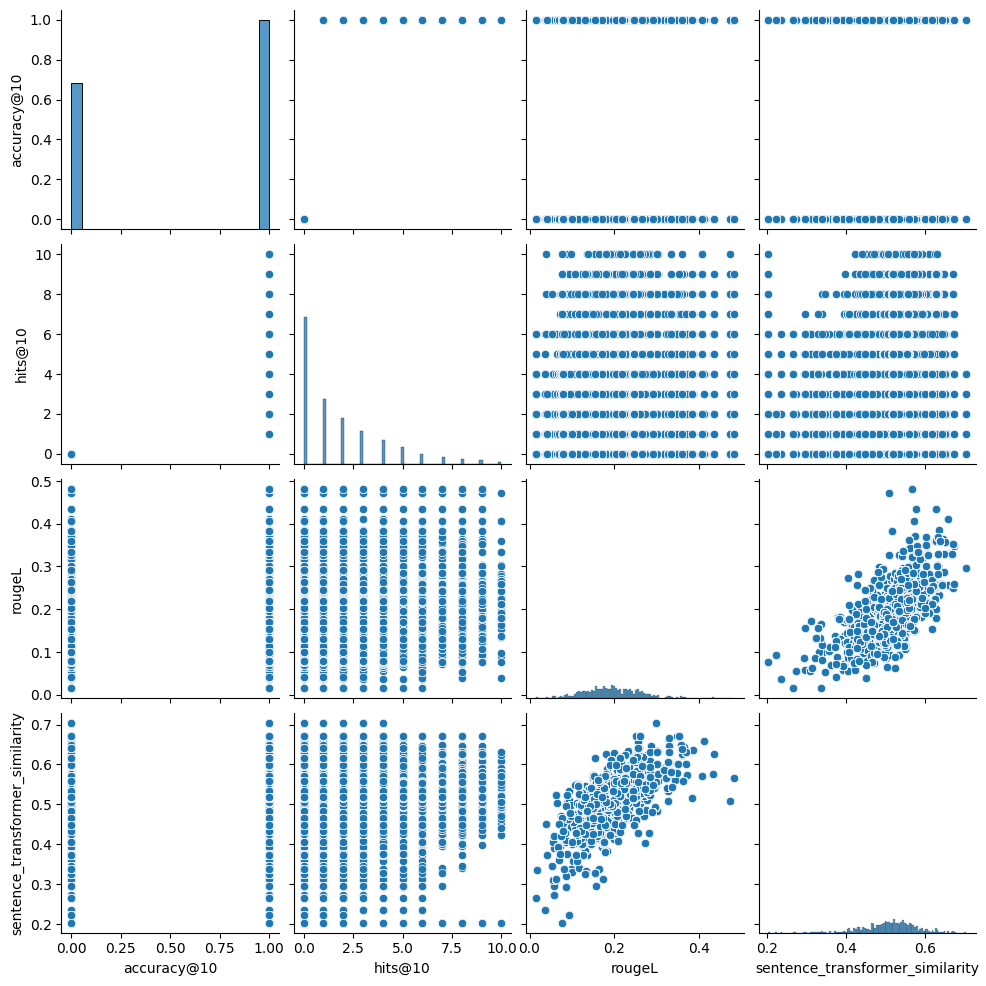

In [52]:
sns.pairplot(per_query_metrics_df.merge(per_query_generation_metrics_df, left_on="query", right_index=True)[["accuracy@10", "hits@10", "rougeL", "sentence_transformer_similarity"]])

In [53]:
worst_queries.shape

(118,)

dependency_signature bm25


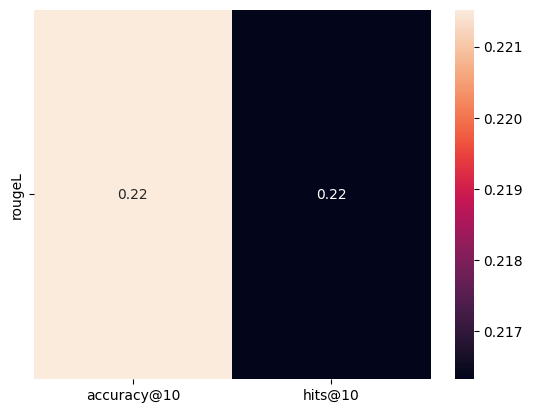

dependency_signature sentence-transformers/all-mpnet-base-v2


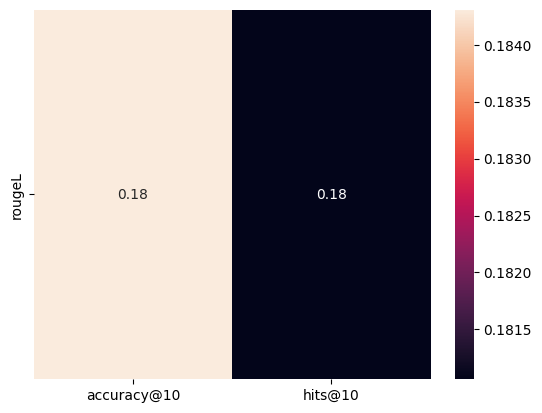

dependency_signature sentence-transformers/all-MiniLM-L12-v2


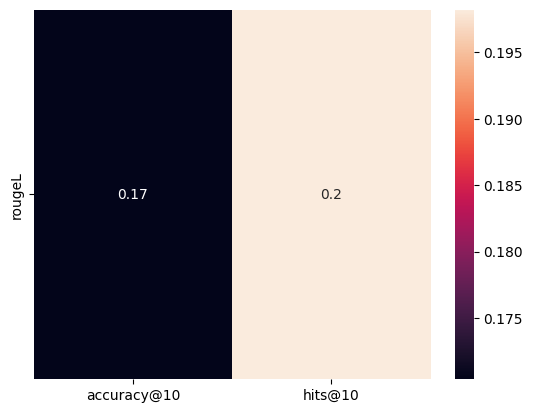

repository_signature bm25


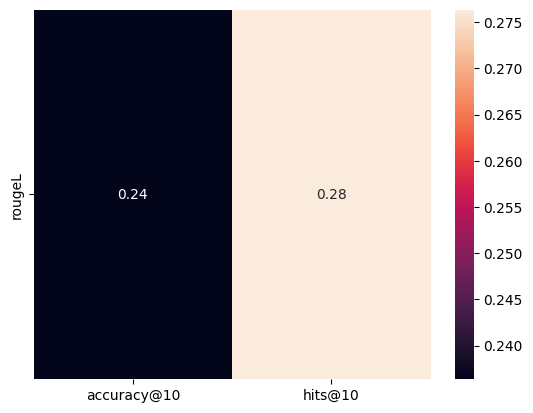

repository_signature sentence-transformers/all-mpnet-base-v2


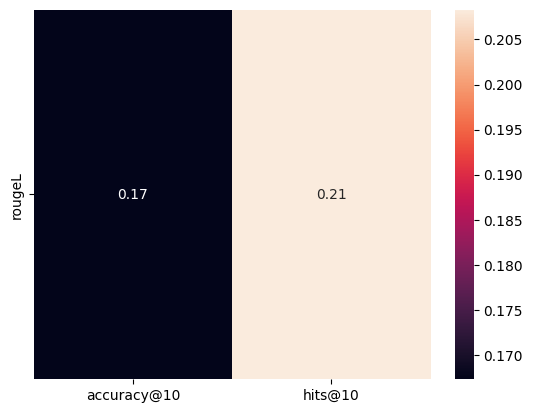

repository_signature sentence-transformers/all-MiniLM-L12-v2


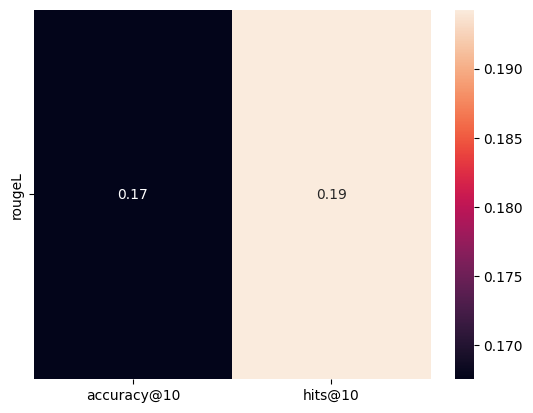

generated_tasks bm25


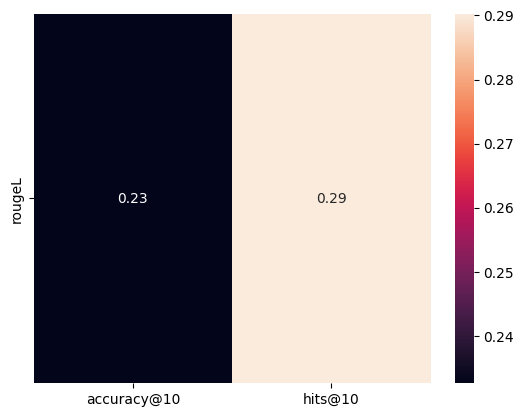

generated_tasks sentence-transformers/all-mpnet-base-v2


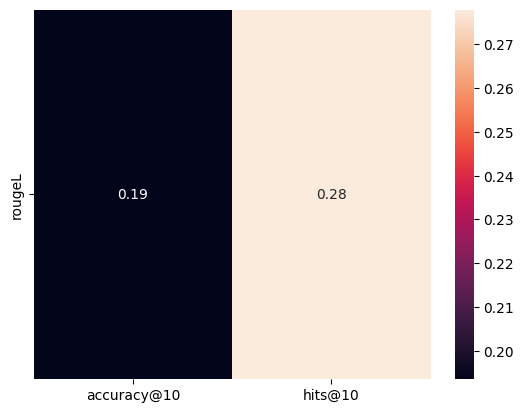

generated_tasks sentence-transformers/all-MiniLM-L12-v2


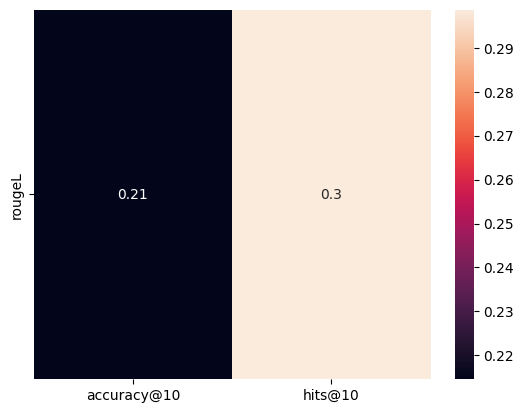

code2doc_generated_readme bm25


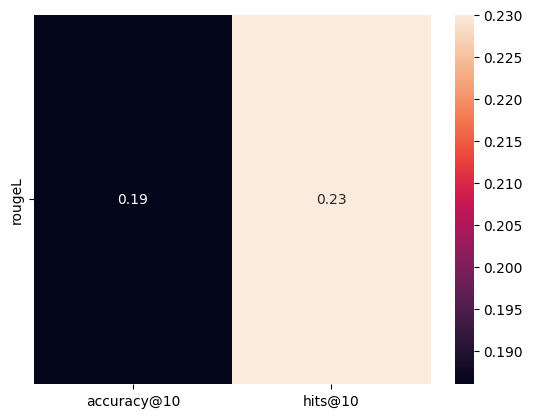

code2doc_generated_readme sentence-transformers/all-mpnet-base-v2


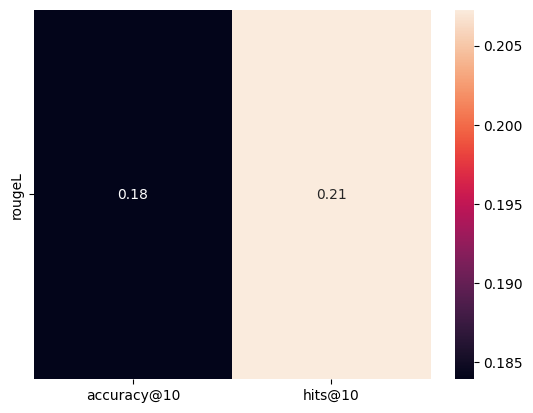

code2doc_generated_readme sentence-transformers/all-MiniLM-L12-v2


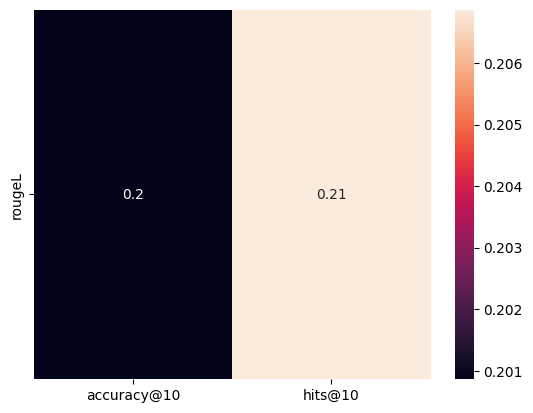

code2doc_reasoning bm25


/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


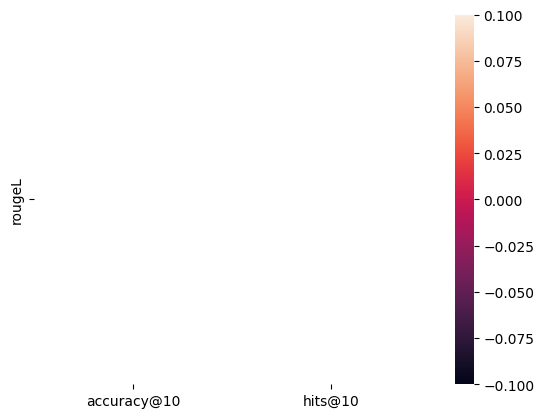

code2doc_reasoning sentence-transformers/all-mpnet-base-v2


/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


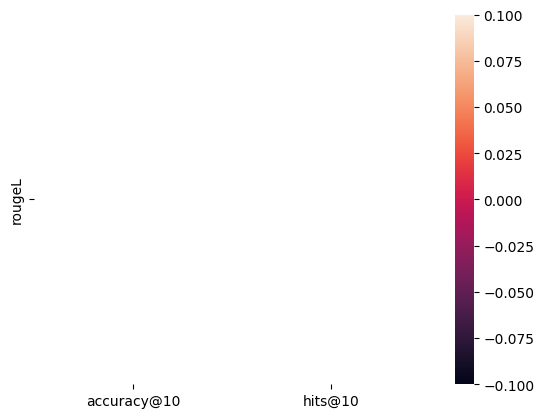

code2doc_reasoning sentence-transformers/all-MiniLM-L12-v2


/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


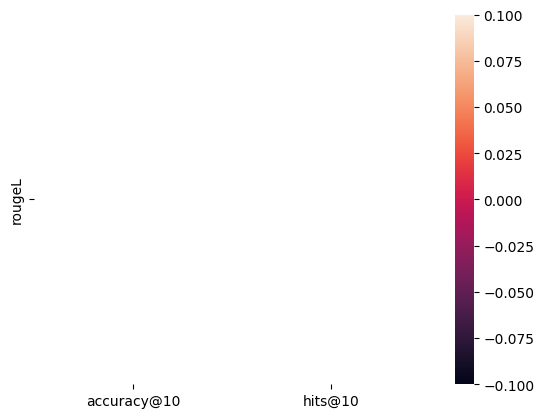

code2doc_generation_context bm25


/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


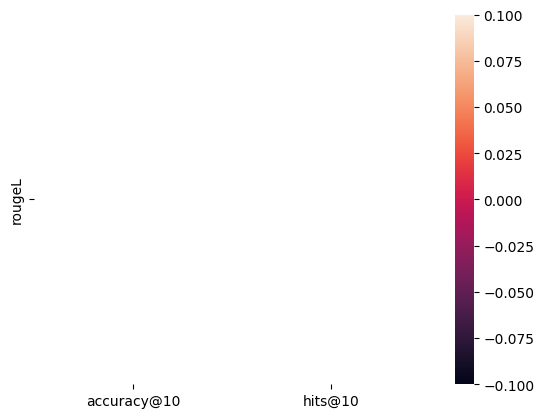

code2doc_generation_context sentence-transformers/all-mpnet-base-v2


/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


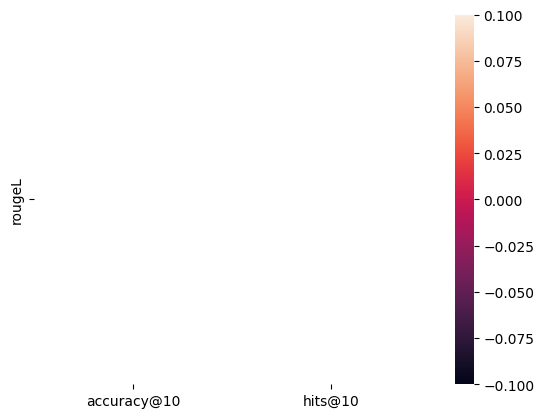

code2doc_generation_context sentence-transformers/all-MiniLM-L12-v2


/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/kuba/Projects/github_search/.venv/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


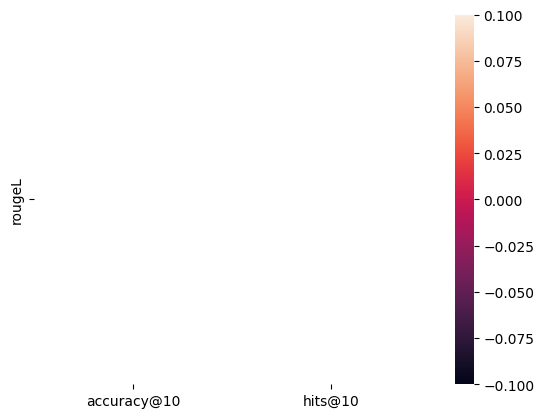

In [54]:
generation_vs_ir_kendall_dfs = []

for corpus_name in checked_corpora:
    for retriever_name in checked_retrievers:
        print(corpus_name, retriever_name)
        selected_metrics_df = per_query_metrics_df[
            (per_query_metrics_df["retriever"] == retriever_name) &
            (per_query_metrics_df["corpus"] == corpus_name)
        ][["query", "accuracy@10", "hits@10"]] 
        #worst_queries_df = per_query_generation_metrics_df.loc[worst_queries]
        corr_df = (
            selected_metrics_df
                .merge(per_query_generation_metrics_df, left_on="query", right_on="task")
                .select_dtypes("float")
                .corr(method="kendall").loc[shown_generation_metrics, ["accuracy@10", "hits@10"]]
        )
        sns.heatmap(corr_df, annot=True)
        plt.show()
        corr_df["retriever"] = [retriever_name]
        corr_df["corpus"] = [corpus_name]
        generation_vs_ir_kendall_dfs.append(corr_df[["corpus", "retriever", "accuracy@10", "hits@10"]])

generation_vs_ir_kendall_df = pd.concat(generation_vs_ir_kendall_dfs)

In [55]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,dependency_signature,bm25,0.221519,0.216320
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.184308,0.181061
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.170397,0.198204
rougeL,repository_signature,bm25,0.236345,0.276355
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.167288,0.208308
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.167513,0.194265
rougeL,generated_tasks,bm25,0.232644,0.290266
rougeL,generated_tasks,sentence-transformers/all-mpnet-base-v2,0.193511,0.277917
rougeL,generated_tasks,sentence-transformers/all-MiniLM-L12-v2,0.214549,0.298675
rougeL,code2doc_generated_readme,bm25,0.185982,0.230000


In [56]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,dependency_signature,bm25,0.221519,0.216320
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.184308,0.181061
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.170397,0.198204
rougeL,repository_signature,bm25,0.236345,0.276355
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.167288,0.208308
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.167513,0.194265
rougeL,generated_tasks,bm25,0.232644,0.290266
rougeL,generated_tasks,sentence-transformers/all-mpnet-base-v2,0.193511,0.277917
rougeL,generated_tasks,sentence-transformers/all-MiniLM-L12-v2,0.214549,0.298675
rougeL,code2doc_generated_readme,bm25,0.185982,0.230000


In [57]:
def corr_df_to_latex(generation_vs_ir_kendall_df):
    generation_vs_ir_kendall_df = generation_vs_ir_kendall_df.copy()
    #generation_vs_ir_kendall_df["corpus"] = generation_vs_ir_kendall_df["corpus"].apply(colorcodings)
    #generation_vs_ir_kendall_df["retriever"] = (
    #    generation_vs_ir_kendall_df["retriever"]
    #        .str.replace("sentence-transformers/all-mpnet-base-v2", "st-MPNet")
    #        .str.replace("sentence-transformers/all-MiniLM-L12-v2", "st-MiniLM")
    #)

    return (
        generation_vs_ir_kendall_df
            .sort_values("hits@10")
            .to_latex(index_names=False, index=False, column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|", float_format="%.2f")
            .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
    )

<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\h'
<>:14: SyntaxWarning: invalid escape sequence '\%'
<>:14: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1533026/2538022487.py:14: SyntaxWarning: invalid escape sequence '\%'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")
/tmp/ipykernel_1533026/2538022487.py:14: SyntaxWarning: invalid escape sequence '\h'
  .replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")


In [58]:
print(corr_df_to_latex(generation_vs_ir_kendall_df.drop(columns=["retriever"]).groupby("corpus").agg("mean").sort_values("hits@10").reset_index()))

\begin{tabular}{|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|}
\hline
\toprule
\hline
corpus & accuracy@10 & hits@10 \\
\hline
\midrule
\hline
dependency signature & 0.19 & 0.20 \\
\hline
code2doc generated readme & 0.19 & 0.21 \\
\hline
repository signature & 0.19 & 0.23 \\
\hline
generated tasks & 0.21 & 0.29 \\
\hline
code2doc generation context & NaN & NaN \\
\hline
code2doc reasoning & NaN & NaN \\
\hline
\bottomrule
\hline
\end{tabular}


In [59]:
generation_vs_ir_kendall_df

,corpus,retriever,accuracy@10,hits@10
rougeL,dependency_signature,bm25,0.221519,0.216320
rougeL,dependency_signature,sentence-transformers/all-mpnet-base-v2,0.184308,0.181061
rougeL,dependency_signature,sentence-transformers/all-MiniLM-L12-v2,0.170397,0.198204
rougeL,repository_signature,bm25,0.236345,0.276355
rougeL,repository_signature,sentence-transformers/all-mpnet-base-v2,0.167288,0.208308
rougeL,repository_signature,sentence-transformers/all-MiniLM-L12-v2,0.167513,0.194265
rougeL,generated_tasks,bm25,0.232644,0.290266
rougeL,generated_tasks,sentence-transformers/all-mpnet-base-v2,0.193511,0.277917
rougeL,generated_tasks,sentence-transformers/all-MiniLM-L12-v2,0.214549,0.298675
rougeL,code2doc_generated_readme,bm25,0.185982,0.230000


In [60]:
def get_metric_diffs(per_query_metrics_df, worst_queries):
    dfs = []
    for name, gp_df in per_query_metrics_df.groupby(["corpus", "retriever"]):
        selected_df = gp_df[gp_df["query"].isin(worst_queries)]
        selected_metrics_df = selected_df[["precision@10", "accuracy@10"]].mean()
        all_metrics_df = gp_df[["precision@10", "accuracy@10"]].mean()
        exp_difference_df = (all_metrics_df - selected_metrics_df)
        diffs = pd.concat([all_metrics_df, selected_metrics_df, exp_difference_df, 100 * (exp_difference_df / all_metrics_df)])
        diffs.index = ["precision@10", "accuracy@10", "worst records precision@10", "worst records accuracy@10", "precision@10 difference", "accuracy@10 difference", "% precision@10 difference", "% accuracy@10 difference"]
        diffs = pd.concat([pd.Series(dict(zip(["corpus", "retriever"], name))), diffs])
        dfs.append(diffs)
    return pd.concat(dfs, axis=1).T

In [61]:
def prettify_diffs_df(diff_df):
    for col in diff_df.columns:
        if "%" in col:
            diff_df[col] = diff_df[col].apply(lambda x: np.round(x,1)).astype(str) + "%"
        else:
            diff_df[col] = diff_df[col].apply(lambda x: np.round(x,3))
    return diff_df

In [62]:
diffs_df = get_metric_diffs(per_query_metrics_df, worst_queries)

In [63]:
aggregated_diffs_df = prettify_diffs_df(diffs_df.drop(columns="retriever").groupby("corpus").agg("mean").sort_values("% precision@10 difference", ascending=False))

In [64]:
per_query_metrics_df[].describe()[["precision@10", "accuracy@10"]]

SyntaxError: invalid syntax (4030047800.py, line 1)

In [ ]:
per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)].describe()[["precision@10", "accuracy@10"]]

In [ ]:
sns.histplot(per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)]["precision@10"], kde=False, stat="probability", label="worst")
sns.histplot(per_query_metrics_df["precision@10"], kde=False, stat="probability", label="all")
plt.legend()
plt.savefig("/home/kuba/Downloads/worst_tasks_hits.png")

The following results show mean hits and accuracy@10 and the difference between these metrics for worst 10% queries as measured by generation metrics.

We investigate these differences further with Mann-Whitney test. The null hypothesis is $H_0: X_{worst} \not< X_{rest}$, that is, hits for the worst queries are not less than for the other queries. Assuming significance level of 0.01 we can refute $H_0$ for all corpora except original READMEs.

In [ ]:



def make_displayed_agg_diffs_df(diffs_df, metric="accuracy"):
    displayed_df = aggregated_diffs_df[[col for col in aggregated_diffs_df.columns if metric in col]].copy()
    displayed_df[f"{metric}@10 difference"] = displayed_df[f"{metric}@10 difference"].apply(str) + " (" + displayed_df[f"% {metric}@10 difference"] + ")"
    displayed_df = displayed_df.drop("readme").reset_index()
    #displayed_df["corpus"] = displayed_df["corpus"].apply(colorcode)
    latex_str = (
        displayed_df
            .drop(columns=[f"% {metric}@10 difference"])
            .to_latex(index_names=False, index=False, column_format="|p{3cm}|p{2.5cm}|p{2cm}|p{2cm}|", float_format="%.3f")
    )
    return latex_str.replace("%", "\%").replace("_", " ").strip().replace("\n", "\n\hline\n")

In [ ]:
aggregated_diffs_df

In [ ]:
aggregated_diffs_df

In [ ]:
print(make_displayed_agg_diffs_df(aggregated_diffs_df))

In [ ]:
print(make_displayed_agg_diffs_df(aggregated_diffs_df, "precision"))

In [ ]:
from statsmodels.stats import weightstats
from statsmodels.stats.nonparametric import rank_compare_2indep
from scipy.stats import mannwhitneyu

In [ ]:
worst_per_query_metrics_df = per_query_metrics_df[per_query_metrics_df["query"].isin(worst_queries)]

In [ ]:
worst_comparison_records = []

for corpus in per_query_metrics_df["corpus"].unique():
    #for retriever in per_query_metrics_df["retriever"].unique():
    subset_df =  per_query_metrics_df[per_query_metrics_df["corpus"] == corpus]
    subset_df = subset_df.groupby(["query"]).apply(lambda df: df.select_dtypes("float").mean()).reset_index()
    #subset_df = subset_df[subset_df["retriever"] == retriever]
    res = mannwhitneyu(
        subset_df[subset_df["query"].isin(worst_queries)]["precision@10"].values,
        subset_df[~subset_df["query"].isin(worst_queries)]["precision@10"].values,
        alternative="less"
    )
    worst_comparison_records.append(dict(corpus=corpus, statistic=res.statistic, pvalue=res.pvalue))
    #print(res)

worst_comparison_df = pd.DataFrame(worst_comparison_records)

In [ ]:
print(worst_comparison_df.sort_values("pvalue").to_latex(index=False, float_format="%.1e",column_format="|c|c|c|").strip().replace("\n", "\n\hline\n").replace("_", " "))